__BIOBSS - PPG Pipeline__

_This notebook includes guidelines to help using pipeline module for PPG signal processing and feature extraction._

In [1]:
#Import BIOBSS and other required packages

#import biobss
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import biobss from local to run without installing
import sys
sys.path.append("../")
import biobss

c:\Users\ipek.karakus\.conda\envs\biolib\lib\site-packages\plotly_resampler\aggregation\aggregators.py:24: UserWarning: Could not import lttbc; will use a (slower) python alternative.
  warnings.warn("Could not import lttbc; will use a (slower) python alternative.")


# Table of Contents
1. [PPG Sample Data](#sampledata)<br>
2. [Create Pipeline Object](#create_pipeline)<br>
3. [Set Pipeline Inputs](#set_input)<br>
4. [Create Bio Process Objects](#create_bioprocess)<br>
5. [Add Bio Process Objects to Pipeline](#add_bioprocess)<br>
6. [Run Preprocessing Pipeline](#run_pipeline)<br>
7. [Create Feature Objects](#create_feature)<br>
8. [Add Feature Objects to Pipeline](#add_feature)
9. [Extract Features](#extract_features)<br>

### __PPG Sample Data__
<a id="sampledata"></a>

PPG sample data is provided as a csv file in BIOBSS\sample data. The data file contains a PPG segment of 40-seconds length, sampled at 64 Hz.

In [2]:
#Load the sample data
data, info = biobss.utils.load_sample_data(data_type='PPG_LONG')
sig = np.asarray(data['PPG'])
fs = info['sampling_rate']
L = info['signal_length']

PPG signal can be plotted using BIOBSS's plotting functions.

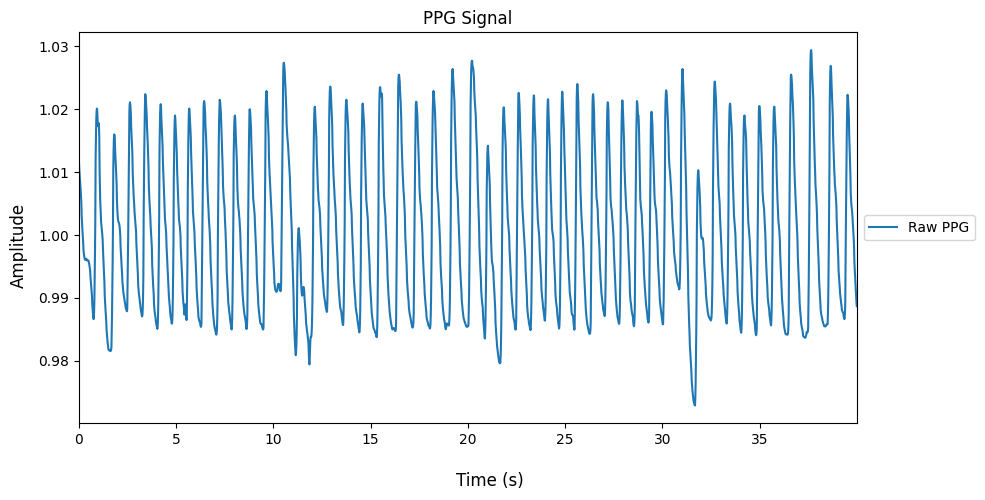

In [3]:
signals = {'Raw':sig}
biobss.ppgtools.plot_ppg(signals=signals, sampling_rate=fs, show_peaks=False, rescale=False, figsize=(10,5))

### __Create Pipeline Object__
<a id="create_pipeline"></a>

First, a pipeline object should be created.

In [4]:
pipeline = biobss.pipeline.Bio_Pipeline()   # Create a pipeline object

For windowed processing, __windowed_process__ should be set as __True__. Additionally, __window_size__ and __step_size __ should be defined. As an example, window_size=10 means that the pipeline will process 10 seconds of data at a time and step_size=5 means signal will be shifted by 5 seconds for each window (overlapped region).

In [5]:
pipeline_windowed = biobss.pipeline.Bio_Pipeline(windowed_process=True,window_size=10,step_size=5)  # Create a pipeline object

### __Set Pipeline Inputs__
<a id="set_input"></a>

Pipeline input can be set using the __set_input__ method. 

In [6]:
# Set the input signal and sampling rate
pipeline.set_input(data=sig, sampling_rate=fs, name='PPG_Raw')
#pipeline_windowed.set_input(data=sig, sampling_rate=fs, name='PPG_Raw') 

### __Create Bio Process Objects__
<a id="create_bioprocess"></a>

Any process can be added to the pipeline by passing the method to a Bio_Process constructor. The Bio_Process constructor takes the following arguments:

- process_method: The method to be added to the pipeline
- process_name: Name of the method to be added to the pipeline
- **kwargs: Keyword arguments to be passed to the process method

Pipeline processes the given input sequentially. The input is passed from one process to the next.

For PPG signal, the processing given below is added to the pipeline:

 1. Filtering signals
    * Signal can be filtered with defining filters
      * <code> biobss.preprocess.filter_signal(sig,sampling_rate=fs,filter_type='bandpass',N=2,f_lower=0.5,f_upper=5) </code>
    * Siganls can be filtered with predefined filters
      * <code> biobss.preprocess.filter_signal(sig, sampling_rate=fs, signal_type='PPG', method='bandpass') </code>
 2. Peak Detection

In [7]:
filter_ppg = biobss.pipeline.Bio_Process(process_method=biobss.ppgtools.filter_ppg,process_name="Filter PPG")
find_peaks = biobss.pipeline.Bio_Process(biobss.ppgtools.ppg_detectpeaks,process_name='Find PPG Peaks',
                                         method='peakdet', delta=0.01, correct_peaks=True)

In [8]:
differentiate = biobss.pipeline.Bio_Process(process_method=biobss.ppgtools.differentiate_ppg, process_name="Differentiate PPG")

In [9]:
find_fiducials = biobss.pipeline.Bio_Process(process_method=biobss.ppgtools.ppg_waves, process_name="Delineate")

In [10]:
pipeline.process_queue.add_process(filter_ppg , input_signals=['PPG_Raw'], output_signals=['PPG_Filtered'], sampling_rate = fs)
pipeline.process_queue.add_process(find_peaks , input_signals=['PPG_Filtered'], output_signals=['PPG_Peaks'], sampling_rate = fs,is_event=True)

In [11]:
pipeline.process_queue.add_process(differentiate, input_signals={'sig':'PPG_Filtered'}, output_signals=['PPG_diff'], sampling_rate=fs, is_event=True)

In [12]:
pipeline.process_queue.add_process(find_fiducials, input_signals={'sig': 'PPG_Filtered', 'locs_onsets':'PPG_Peaks_Trough_locs'}, output_signals=['PPG_Fiducials'], sampling_rate=fs, is_event=True)

The pipeline can be run using the __run_pipeline__ method. 

In [13]:
pipeline.run_pipeline()

{'vpg_sig': array([-0.0345428 , -0.03370568, -0.03154254, ...,  0.00178664,
        0.00739589,  0.00973213]), 'apg_sig': array([0.05357616, 0.09600855, 0.1521402 , ..., 0.40636459, 0.25425566,
       0.14951939])}


c:\Users\ipek.karakus\Desktop\BIOBSS\examples\..\biobss\ppgtools\ppg_filter.py:43: UserWarning: Default parameters will be used for filtering. 2th order bandpass filter with f1=0.5 Hz and f2=5 Hz.
  warnings.warn(


The pipeline data can be accessed using the attribute __data__.

In [14]:
pipeline.data

Signal object with 18 channel(s)
PPG_Raw (64Hz) (1 windows) ((2560,))
PPG_Filtered (64Hz) (1 windows) ((2560,))
PPG_Peaks_Peak_locs (64Hz) (1 windows)
PPG_Peaks_Trough_locs (64Hz) (1 windows)
PPG_diff_vpg_sig (64Hz) (1 windows)
PPG_diff_apg_sig (64Hz) (1 windows)
PPG_Fiducials_O_waves (64Hz) (1 windows)
PPG_Fiducials_S_waves (64Hz) (1 windows)
PPG_Fiducials_N_waves (64Hz) (1 windows)
PPG_Fiducials_D_waves (64Hz) (1 windows)
PPG_Fiducials_w_waves (64Hz) (1 windows)
PPG_Fiducials_y_waves (64Hz) (1 windows)
PPG_Fiducials_z_waves (64Hz) (1 windows)
PPG_Fiducials_a_waves (64Hz) (1 windows)
PPG_Fiducials_b_waves (64Hz) (1 windows)
PPG_Fiducials_e_waves (64Hz) (1 windows)
PPG_Fiducials_c_waves (64Hz) (1 windows)
PPG_Fiducials_d_waves (64Hz) (1 windows)

In order the processed data, signals and peaks can be defined as shown below.

In [15]:
signals={'Raw': pipeline.data['PPG_Raw'].channel, 'Filtered': pipeline.data['PPG_Filtered'].channel}
peaks={'Filtered':{'Peaks': pipeline.data['PPG_Peaks_Peak_locs'].channel, 'Onsets': pipeline.data['PPG_Peaks_Trough_locs'].channel}}

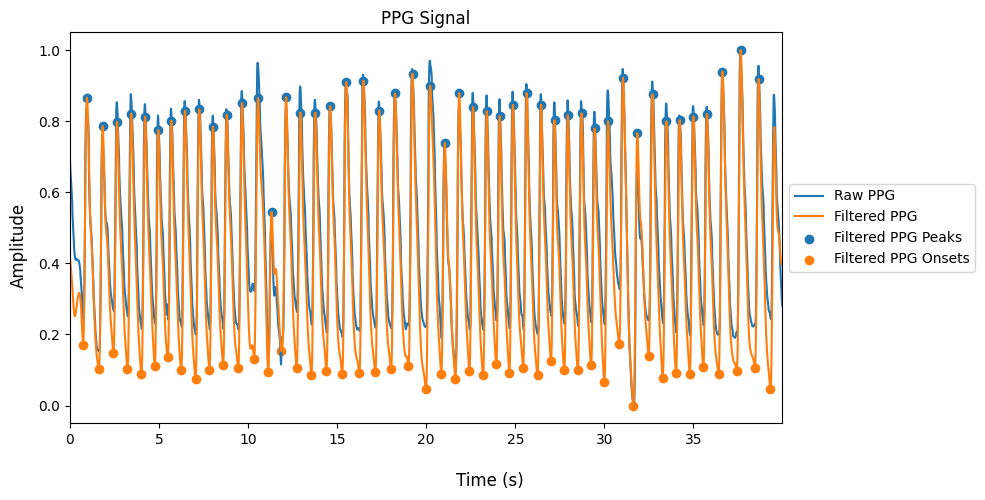

In [16]:
biobss.ppgtools.plot_ppg(signals=signals, peaks=peaks, sampling_rate=fs, show_peaks=True, rescale=True, figsize=(10,5))

Same steps can be applied for windowed data by replacing __pipeline__ object with __pipeline_windowed__ object in the cells above.

### __Create Feature Objects__ 
<a id="create_feature"></a>

Feature extraction steps can be added to the pipeline by passing the method to a Feature constructor. The Feature constructor takes the following arguments:

- function: The function to be used for feature extraction
- name: Name of the feature set
- **kwargs: Keyword arguments to be passed to the function

Feature extraction steps are applied simultaneously. Outputs of all feature extraction steps are merged at the end.

For PPG signals, features can be extracted by defining the domain (time,frequency,statistical), input type (cycle, segment) or both. For details, see the [tutorial notebook for PPG signal processing](https://github.com/obss/BIOBSS/blob/main/examples/ppg_processing.ipynb).  

In [17]:
# Frequency domain features
ppg_freq = biobss.pipeline.feature_extraction.Feature(function = biobss.ppgtools.ppg_features.ppg_freq_features,name='PPG_Frequency', input_types=['segment'])
# Time domain features
ppg_time = biobss.pipeline.feature_extraction.Feature(function= biobss.ppgtools.ppg_features.ppg_time_features, name='PPG_Time', input_types=['cycle','segment'])
#Statistical features
ppg_stat = biobss.pipeline.feature_extraction.Feature(function = biobss.ppgtools.ppg_features.ppg_stat_features,name='PPG_Statistics', input_types=['cycle','segment'])

In [18]:
pipeline.add_feature_step(ppg_freq, input_signals={'sig': 'PPG_Filtered'}, sampling_rate= fs)
pipeline.add_feature_step(ppg_time, input_signals={'sig': 'PPG_Filtered','peaks_locs' : 'PPG_Peaks_Peak_locs', 'troughs_locs': 'PPG_Peaks_Trough_locs' }, sampling_rate = fs)
pipeline.add_feature_step(ppg_stat, input_signals={'sig': 'PPG_Filtered','peaks_locs' : 'PPG_Peaks_Peak_locs', 'troughs_locs': 'PPG_Peaks_Trough_locs' }, sampling_rate = fs)

In [19]:
vpg_features = biobss.pipeline.feature_extraction.Feature(function=biobss.ppgtools.vpg_features.get_vpg_features, name='VPG_features',fiducials={'w_waves': pipeline.data['PPG_Fiducials_w_waves'].channel, 'y_waves':pipeline.data['PPG_Fiducials_y_waves'].channel, 'z_waves':pipeline.data['PPG_Fiducials_z_waves'].channel})

In [21]:
pipeline.add_feature_step(vpg_features, input_signals={'vpg_sig':'PPG_diff_vpg_sig', 'locs_O':'PPG_Peaks_Trough_locs'}, sampling_rate=fs)

In [22]:
pipeline.extract_features()
pipeline.features

TypeError: list indices must be integers or slices, not list